In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("./")))
from ase.build.ribbon import graphene_nanoribbon
from TB.hamiltonian import Hamiltonian
from TB.orbitals import Orbitals
from calc.utils import finite_difference
from TB.hamiltonian_initializer import set_tb_params, set_tb_params_bond_length
import torch
from calc.NEGF import NEGF

def create_graphene_nanoribbon(w=3.5, l=5):
    atoms = graphene_nanoribbon(w, l, type='armchair', saturated=True)

    period = np.array([list(atoms.get_cell()[2])])
    period[:, [1, 2]] = period[:, [2, 1]]
    coord = atoms.get_positions()

    coord[:, [1, 2]] = coord[:, [2, 1]]
    coords = []
    coords.append(str(len(coord)))
    coords.append('Nanoribbon')

    for j, item in enumerate(coord):
        coords.append('C' + str(j + 1) + ' ' + str(item[0]) + ' ' + str(item[1]) + ' ' + str(item[2]))

    coords = '\n'.join(coords)

    return period, coords

import numpy as np

def radial_dependence_func(bond_length, ne_bond_length, param):

        return (bond_length / ne_bond_length) ** param
        # return torch.exp(-param*(ne_bond_length/bond_length-1))

def sorting(coords, **kwargs):
    return np.argsort(coords[:, 1], kind='mergesort')

gamma0 = -2.97
gamma1 = -0.073
gamma2 = -0.33
s0 = 0.073
s1 = 0.018
s2 = 0.026



In [2]:
import time
import resource

time_count = {"na":[], "Seebeck":{"FD":[], "AD":[], "FD_mem":[], "AD_mem":[]}}
for l in range(1, 6):
    period, coords = create_graphene_nanoribbon(w=3.5, l=l)

    s_orb = Orbitals('C')
    s_orb.add_orbital("pz", energy=-0.28, orbital=1, magnetic=0, spin=0)

    set_tb_params(s_orb, PARAMS_C_C1={'pp_pi': gamma0},
                    PARAMS_C_C2={'pp_pi': gamma1},
                    PARAMS_C_C3={'pp_pi': gamma2},
                    OV_C_C1={'pp_pi': s0},
                    OV_C_C2={'pp_pi': s1},
                    OV_C_C3={'pp_pi': s2})

    h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=[1.5, 2.5, 3.1], comp_overlap=True, sort_func=sorting).initialize()
    h.set_periodic_bc(period)
    n_a = h.get_site_coordinates().shape[0]
    time_count["na"].append(n_a)

    hL, hD, hR, sL, sD, sR = h.get_hamiltonians()
    hl_list, hd_list, hr_list, sl_list, sd_list, sr_list, subblocks = \
        h.get_hamiltonians_block_tridiagonal(optimized=True)
        

    def pack(**options):
        return options

    hmt_ovp = pack(hd=hd_list,hu=hr_list,hl=hl_list,sd=sd_list,su=sr_list,sl=sl_list,lhd=hD,lhu=hL.conj().T,lsd=sD,lsu=sL.conj().T,rhd=hD,rhu=hR,rsd=sD,rsu=sR)
    # plt.matshow(hD.detach().real, vmin=-5, vmax=0.5)
    # plt.colorbar()
    negf = NEGF(hmt_ovp)

    ee = torch.linspace(-3, 3, 1)

    startAD = time.time()
    startusageAD = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    result = negf.calGreen(
        ee = ee,
        ul = 0.,
        ur = 1.,
        calSeebeck=True,
        cutoff=True,
        ifSCF=False,
        d_trains=1,
        left_pos=period[0][0],
        right_pos=period[0][1],
        atom_coord=h.get_site_coordinates()[h._offsets],
        offset=h._offsets,
        sgfMethod="iterative"
    )
    endusageAD = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    endAD = time.time()
    time_count["Seebeck"]["AD"].append(endAD - startAD)
    time_count["Seebeck"]["AD_mem"].append(endusageAD - startusageAD)

        # FD
    startFD = time.time()

    
    with torch.no_grad():
        f = lambda x: negf.calGreen(
            ee = x,
            ul = 0.,
            ur = 1.,
            calSeebeck=False,
            calTT=True,
            cutoff=True,
            ifSCF=False,
            d_trains=1,
            left_pos=period[0][0],
            right_pos=period[0][1],
            atom_coord=h.get_site_coordinates()[h._offsets],
            offset=h._offsets,
            sgfMethod="iterative"
        )["TT"].view(-1)
        for ie in ee:
            startusageFD = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            finite_difference(fn=f, x=ie, h=1e-5).detach()
            endusageFD = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    endFD = time.time()
    time_count["Seebeck"]["FD"].append(endFD - startFD)
    time_count["Seebeck"]["FD_mem"].append(endusageFD - startusageFD)

    # 
    # Diff w.r.t. Hamiltonian

torch.save(obj=time_count, f="./timecount/memtime_noimp.pth")



C
C
C
C
C


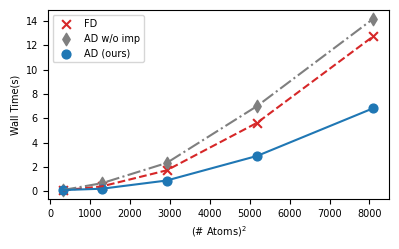

In [1]:
import torch

def linear(X, Y, start, end, num):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    X = torch.stack([X,torch.ones_like(X)], dim=1)
    W = (X.T @ X).inverse() @ X.T @ Y.unsqueeze(1)
    

    x = torch.linspace(start=start, end=end, steps=num)
    y = torch.stack([x, torch.ones_like(x)], dim=1) @ W
    return x, y

a = torch.load("./timecount/memtime_noimp.pth")
b = torch.load("./timecount/memtime.pth")

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(4,2.5))
plt.scatter([i**2 for i in a["na"]],a["Seebeck"]["FD"],  s=40, marker="x", c='tab:red', label="FD")
x, y = linear([i**2 for i in a["na"]], a["Seebeck"]["FD"], start=10, end=5000, num=100)
plt.plot([i**2 for i in a["na"]],a["Seebeck"]["FD"],'--',c='tab:red')

plt.scatter([i**2 for i in a["na"]],a["Seebeck"]["AD"],  s=40, marker="d", c='tab:gray', label="AD w/o imp")
x, y = linear([i**2 for i in a["na"]], a["Seebeck"]["AD"], start=10, end=5000, num=100)
plt.plot([i**2 for i in a["na"]],a["Seebeck"]["AD"],'-.',c='tab:gray')

plt.scatter([i**2 for i in b["na"]],b["Seebeck"]["AD"],  s=40, marker="o", c='tab:blue', label="AD (ours)")
x, y = linear([i**2 for i in b["na"]], b["Seebeck"]["AD"], start=10, end=5000, num=100)
plt.plot([i**2 for i in a["na"]],b["Seebeck"]["AD"],c='tab:blue')

plt.xlabel(r"(# Atoms)$^2$")
plt.ylabel("Wall Time(s)")
# plt.title("Walltime of Backpropagation of 1D Seebeck Coefficient")
plt.legend(loc="best")
plt.tight_layout()
# plt.ylim(-100,200)
plt.savefig("../img/Cost.pdf", dpi=100)
plt.show()

# fig = plt.figure(figsize=(4,2.5))
# plt.scatter(a["na"],a["TT"]["FD"],  s=40, marker="x", c='tab:red', label="w/ Op Tracking")
# x, y = linear(a["na"], a["TT"]["FD"], start=10, end=170, num=100)
# plt.plot(x,y, '--',c="tab:red")
# plt.scatter(a["na"],a["TT"]["AD"],  s=40, marker="x", c='tab:blue', label="w/o Op Tracking")
# x, y = linear(a["na"], a["TT"]["AD"], start=10, end=170, num=100)
# plt.plot(x,y, c="tab:blue")
# plt.xlabel("# atoms")
# plt.ylabel("CPU time")
# plt.title("Runtime of Forward Simulation")
# plt.legend(loc="upper left")
# plt.tight_layout()
# plt.savefig("../img/CostFW.pdf", dpi=100)
# plt.show()

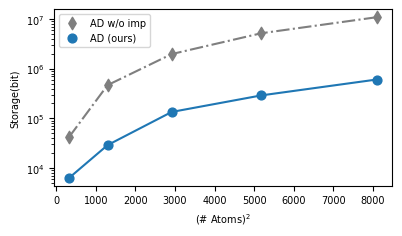

In [2]:
import torch

def linear(X, Y, start, end, num):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    X = torch.stack([X,torch.ones_like(X)], dim=1)
    W = (X.T @ X).inverse() @ X.T @ Y.unsqueeze(1)

    x = torch.linspace(start=start, end=end, steps=num)
    y = torch.stack([x, torch.ones_like(x)], dim=1) @ W
    return x, y

a = torch.load("./timecount/memtime_noimp.pth")
b = torch.load("./timecount/memtime.pth")

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(4,2.5))
# plt.scatter([i**2 for i in a["na"]],a["Seebeck"]["FD_mem"],  s=40, marker="x", c='tab:red', label="FD")
# x, y = linear([i**2 for i in a["na"]], a["Seebeck"]["FD_mem"], start=10, end=5000, num=100)
# plt.plot(x,y,'--', c="tab:red")

plt.scatter([i**2 for i in a["na"]],a["Seebeck"]["AD_mem"],  s=40, marker="d", c='tab:gray', label="AD w/o imp")
plt.plot([i**2 for i in a["na"]],a["Seebeck"]["AD_mem"],'-.',c='tab:gray')
# x, y = linear([i**2 for i in a["na"]], a["Seebeck"]["AD_mem"], start=10, end=5000, num=100)
# plt.plot(x,y, c="tab:blue")

plt.scatter([i**2 for i in b["na"]],b["Seebeck"]["AD_mem"],  s=40, marker="o", c='tab:blue', label="AD (ours)")
plt.plot([i**2 for i in a["na"]],b["Seebeck"]["AD_mem"],c='tab:blue')
# x, y = linear([i**2 for i in b["na"]], b["Seebeck"]["AD_mem"], start=10, end=5000, num=100)
# plt.plot(x,y,'-.', c="tab:gray")

plt.xlabel(r"(# Atoms)$^2$")
plt.ylabel("Storage(bit)")
# plt.title("Storage of Backpropagation of 1D Seebeck Coefficient")
plt.legend(loc="best")
plt.tight_layout()
# plt.ylim(-100,200)
plt.yscale("log")
plt.savefig("../img/Storage.pdf", dpi=100)
plt.show()

# fig = plt.figure(figsize=(4,2.5)
# )
# plt.scatter(a["na"],a["TT"]["FD"],  s=40, marker="x", c='tab:red', label="w/ Op Tracking")
# x, y = linear(a["na"], a["TT"]["FD"], start=10, end=170, num=100)
# plt.plot(x,y, '--',c="tab:red")
# plt.scatter(a["na"],a["TT"]["AD"],  s=40, marker="x", c='tab:blue', label="w/o Op Tracking")
# x, y = linear(a["na"], a["TT"]["AD"], start=10, end=170, num=100)
# plt.plot(x,y, c="tab:blue")
# plt.xlabel("# atoms")
# plt.ylabel("CPU time")
# plt.title("Runtime of Forward Simulation")
# plt.legend(loc="upper left")
# plt.tight_layout()
# plt.savefig("../img/CostFW.pdf", dpi=100)
# plt.show()

In [7]:
b["Seebeck"]["AD_mem"]

[6316, 28924, 134668, 290712, 606908]

In [18]:
period, coords = create_graphene_nanoribbon(w=3.5, l=2)

s_orb = Orbitals('C')
s_orb.add_orbital("pz", energy=-0.28, orbital=1, magnetic=0, spin=0)

set_tb_params(s_orb, PARAMS_C_C1={'pp_pi': gamma0},
                PARAMS_C_C2={'pp_pi': gamma1},
                PARAMS_C_C3={'pp_pi': gamma2},
                OV_C_C1={'pp_pi': s0},
                OV_C_C2={'pp_pi': s1},
                OV_C_C3={'pp_pi': s2})

h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=[1.5, 2.5, 3.1], comp_overlap=True, sort_func=sorting).initialize()
h.set_periodic_bc(period)
n_a = h.get_site_coordinates().shape[0]

hL, hD, hR, sL, sD, sR = h.get_hamiltonians()
hl_list, hd_list, hr_list, sl_list, sd_list, sr_list, subblocks = \
    h.get_hamiltonians_block_tridiagonal(optimized=True)
    

def pack(**options):
    return options

hmt_ovp = pack(hd=hd_list,hu=hr_list,hl=hl_list,sd=sd_list,su=sr_list,sl=sl_list,lhd=hD,lhu=hL.conj().T,lsd=sD,lsu=sL.conj().T,rhd=hD,rhu=hR,rsd=sD,rsu=sR)
# plt.matshow(hD.detach().real, vmin=-5, vmax=0.5)
# plt.colorbar()
negf = NEGF(hmt_ovp)

# ee = torch.tensor(1.3939)
ee = torch.linspace(-3,3,1000)

result = negf.calGreen(
    ee = ee,
    ul = 0.,
    ur = 1.,
    calSeebeck=True,
    cutoff=True,
    ifSCF=False,
    d_trains=1,
    left_pos=period[0][0],
    right_pos=period[0][1],
    atom_coord=h.get_site_coordinates()[h._offsets],
    offset=h._offsets,
    sgfMethod="other",
    etaLead=1e-2, 
    etaDevice=1e-2
)

C


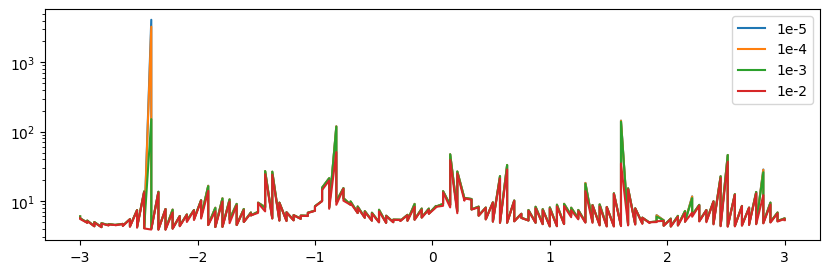

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,3))
data2 = np.loadtxt("/data/ADNEGF/data/norm_gs/gs-2.txt")
data3 = np.loadtxt("/data/ADNEGF/data/norm_gs/gs-3.txt")
data4 = np.loadtxt("/data/ADNEGF/data/norm_gs/gs-4.txt")
data5 = np.loadtxt("/data/ADNEGF/data/norm_gs/gs-5.txt")

plt.plot(ee.unsqueeze(1).repeat(1,2).view(-1), data5, label="1e-5")
plt.plot(ee.unsqueeze(1).repeat(1,2).view(-1), data4, label="1e-4")
plt.plot(ee.unsqueeze(1).repeat(1,2).view(-1), data3, label="1e-3")
plt.plot(ee.unsqueeze(1).repeat(1,2).view(-1), data2, label="1e-2")
plt.yscale("log")
# plt.ylim(2, 100)
plt.legend()
plt.show()

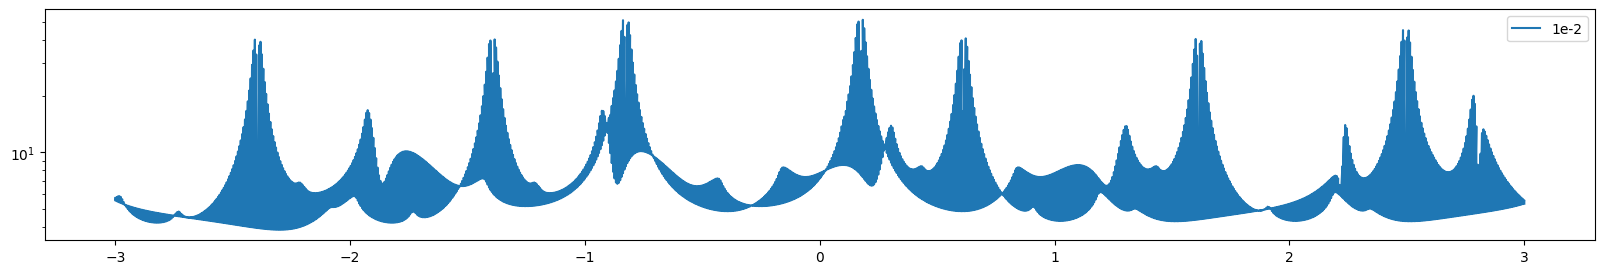

In [22]:
fig = plt.figure(figsize=(20,3))
data2 = np.loadtxt("/data/ADNEGF/data/norm_gs/gs-2.txt")

plt.plot(ee.unsqueeze(1).repeat(1,2).view(-1), data2, label="1e-2")
plt.yscale("log")
plt.legend()
plt.show()
